# Import and install required Librarie/Packages**

In [ ]:
# Package/Library for stemming Bahasa
!pip install Sastrawi
# Package/Library for use model transformers
!pip install transformers

!pip install googletrans==3.1.0a0

In [ ]:
# NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud, STOPWORDS

# Data Manipulation
import os
import csv
import pandas as pd
import io
import numpy as np
import itertools
import statistics
import time
import datetime

# Ignore Warning Error
import warnings
warnings.filterwarnings("ignore")

# Model IndoBERT
import random
import transformers
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split, RandomSampler, SequentialSampler
from pylab import rcParams

# Splitting
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
from textwrap import wrap

# Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

# Pengaturan visualisasi
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='darkgrid', palette='bright', font_scale=1.5)

# Definisi palet warna khusus
MY_CUSTOM_PALETTE = ["#2ECC71", "#3498DB", "#E74C3C", "#9B59B6", "#F1C40F", "#E67E22"]
sns.set_palette(sns.color_palette(MY_CUSTOM_PALETTE))
rcParams['figure.figsize'] = 8, 5

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#check GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    num_gpus = torch.cuda.device_count()
    gpu_name = torch.cuda.get_device_name(0)
    print(f'There are {num_gpus} GPU(s) available.')
    print(f'We will use the GPU: {gpu_name}')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


#Load DATASET


In [ ]:
#read dataset
data = pd.read_csv('/content/dataset(final).csv')
data

,full_text
0,Menyatakan oposisi setelah pelantikan presiden...
1,Sampai saat ini kondisi politik dan pertumbuha...
2,MPR lembaga tertinggi Negara ?berhak menolak p...
3,Menyalaa Jenderal Kami menantikan Pelantikan P...
4,pelantikan presiden baru kalo ada kebijakannya...
...,...
5278,udh ada pengumuman gitu.????apa jangan jangan ...
5279,Semoga dimudahkan dan amanah ya pak?
5280,Gila ngeliat muka prabowo setenang itu
5281,PERIHATIN. PEMILU PENUH KECURANGAN.


##WORDCLOUD

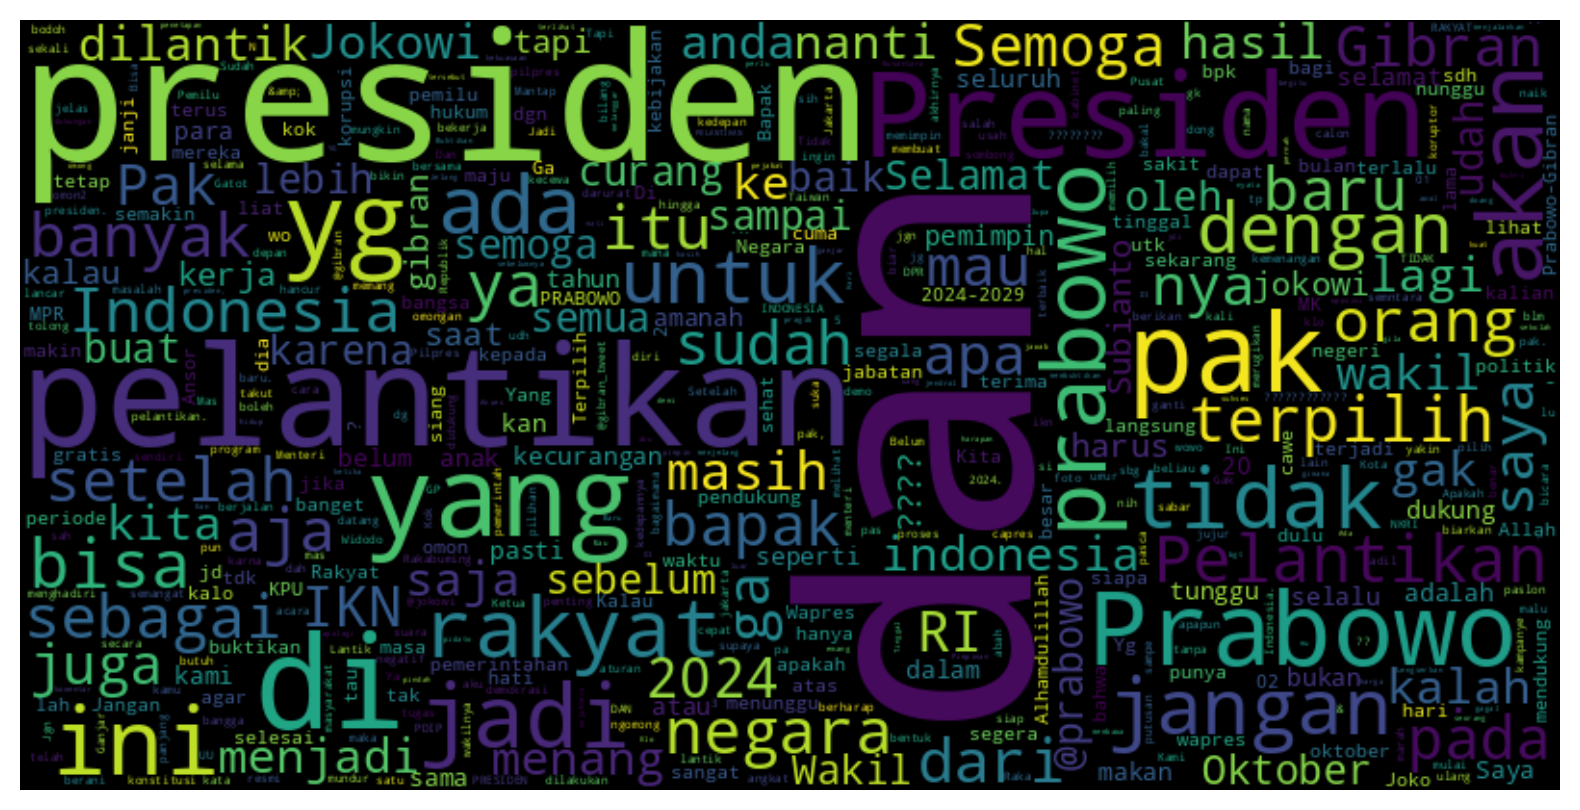

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from collections import Counter

# Gabungkan teks dari kolom 'full_text'
df = ' '.join(data['full_text'].tolist())

# Tentukan stopwords
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp'])

# Hitung frekuensi kata
word_counts = Counter(df.split())

# Buat WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", max_words=500, width=800, height=400)
wc.generate_from_frequencies(word_counts)

# Tampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


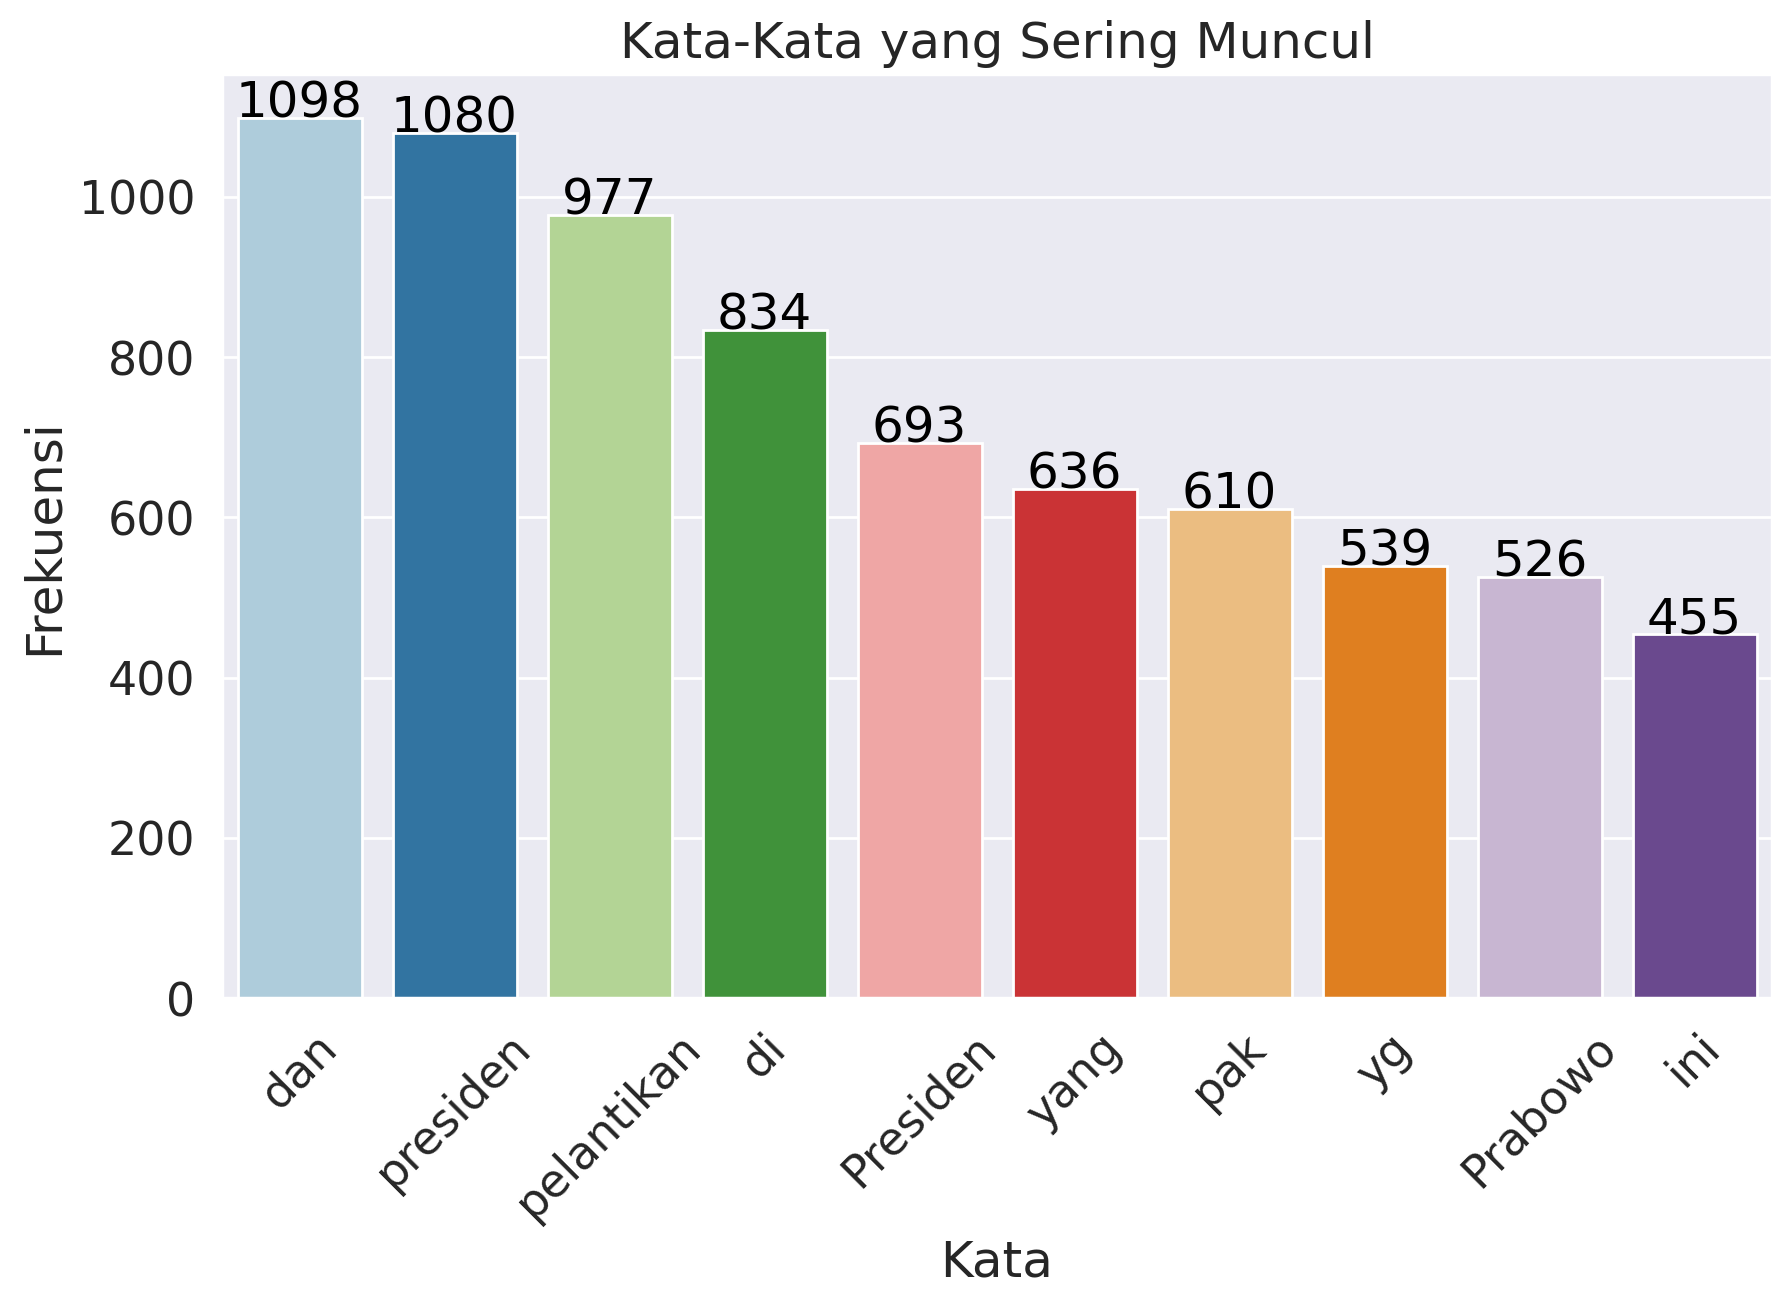

In [ ]:
import pandas as pd
import seaborn as sns
from collections import Counter

# Gabungkan teks dari kolom 'full_text'
text = " ".join(data["full_text"])

# Tokenisasi teks dan hitung frekuensi kata
tokens = text.split()
word_counts = Counter(tokens)

# Ambil 10 kata yang paling sering muncul
top_words = word_counts.most_common(10)
df_top_words = pd.DataFrame(top_words, columns=['word', 'count'])

# Visualisasi dengan seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_top_words, palette="Paired")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.title("Kata-Kata yang Sering Muncul")
plt.xticks(rotation=45)

# Tambahkan label frekuensi di atas batang
for index, row in df_top_words.iterrows():
    plt.text(index, row['count'] + 1, row['count'], color='black', ha="center")

plt.show()


#  Preprocessing Text




##Case Folding/Lowercase


In [ ]:
#lowercase
data['Case Folding'] = data['full_text'].str.lower()
data.head(10)

,full_text,Case Folding
0,Menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...
1,Sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...
2,MPR lembaga tertinggi Negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...
3,Menyalaa Jenderal Kami menantikan Pelantikan P...,menyalaa jenderal kami menantikan pelantikan p...
4,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...
5,Sepertinya setelah pelantikan presiden dunia m...,sepertinya setelah pelantikan presiden dunia m...
6,Saya menjadi presiden bagi rakyat Indonesia. ...,saya menjadi presiden bagi rakyat indonesia. ...
7,Pelantikan presiden baru kok lama sekali,pelantikan presiden baru kok lama sekali
8,Pengen banget segera ada pelantikan Presiden a...,pengen banget segera ada pelantikan presiden a...
9,Menjelang pelantikan presiden terpilih smg td...,menjelang pelantikan presiden terpilih smg td...


##CLEANING

In [ ]:
# Remove special text
def remove_text_special(text):
    if isinstance(text, str):
        text = re.sub(r'[^\x00-\x7f]',r' ', text)   # Remove non-ascii characters
        text = re.sub(r'\.{2,}', ' ', text)   # Replace 2+ dots with space
        text = re.sub('@[^\s]+',' ',text)   # Remove @username
        text = re.sub(r'^RT[\s]+', ' ', text)  # Remove old style retweet text "RT"
        text = text.replace("\\n", " ")  # Remove newline
        # text = re.sub(r'#', '', text)   # Jangan hapus hashtag, bisa penting untuk sentimen
        text = re.sub(r"\b[a-zA-Z]\b", " ", text)  # Remove single character
        text = re.sub('[0-9]+', ' ', text)   # Remove numbers
        text = re.sub(r"http\S+", " ", text)   # Remove URL
        # Pertahankan tanda seru dan tanda tanya
        text = re.sub(f"[{re.escape(string.punctuation).replace('!', '').replace('?', '')}]", " ", text)
        text = text.strip(' "\' ')   # Strip space, " and ' from tweet
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
        text = re.sub(r'\s+$', '', text)  # Remove trailing space
        return re.sub(r'(.)\1{2,}', r'\1', text)  # Remove repeated characters kecuali yang perlu seperti tanda seru
    else:
        return text


data['cleaning'] = data['Case Folding'].apply(remove_text_special)
# data['cleaning'] = data['cleaning'].apply(remove_repeated_characters)
data.head(10)

,full_text,Case Folding,cleaning
0,Menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...
1,Sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...
2,MPR lembaga tertinggi Negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...
3,Menyalaa Jenderal Kami menantikan Pelantikan P...,menyalaa jenderal kami menantikan pelantikan p...,menyalaa jenderal kami menantikan pelantikan p...
4,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...
5,Sepertinya setelah pelantikan presiden dunia m...,sepertinya setelah pelantikan presiden dunia m...,sepertinya setelah pelantikan presiden dunia m...
6,Saya menjadi presiden bagi rakyat Indonesia. ...,saya menjadi presiden bagi rakyat indonesia. ...,saya menjadi presiden bagi rakyat indonesia sa...
7,Pelantikan presiden baru kok lama sekali,pelantikan presiden baru kok lama sekali,pelantikan presiden baru kok lama sekali
8,Pengen banget segera ada pelantikan Presiden a...,pengen banget segera ada pelantikan presiden a...,pengen banget segera ada pelantikan presiden a...
9,Menjelang pelantikan presiden terpilih smg td...,menjelang pelantikan presiden terpilih smg td...,menjelang pelantikan presiden terpilih smg tdk...


##Tokenizing

In [ ]:
# Tokenizing
def word_tokenize_wrapper(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return text

data['Tokenize'] = data['cleaning'].apply(word_tokenize_wrapper)

data.head(10)


,full_text,Case Folding,cleaning,Tokenize
0,Menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,"[menyatakan, oposisi, setelah, pelantikan, pre..."
1,Sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,"[sampai, saat, ini, kondisi, politik, dan, per..."
2,MPR lembaga tertinggi Negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,"[mpr, lembaga, tertinggi, negara, ?, berhak, m..."
3,Menyalaa Jenderal Kami menantikan Pelantikan P...,menyalaa jenderal kami menantikan pelantikan p...,menyalaa jenderal kami menantikan pelantikan p...,"[menyalaa, jenderal, kami, menantikan, pelanti..."
4,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,"[pelantikan, presiden, baru, kalo, ada, kebija..."
5,Sepertinya setelah pelantikan presiden dunia m...,sepertinya setelah pelantikan presiden dunia m...,sepertinya setelah pelantikan presiden dunia m...,"[sepertinya, setelah, pelantikan, presiden, du..."
6,Saya menjadi presiden bagi rakyat Indonesia. ...,saya menjadi presiden bagi rakyat indonesia. ...,saya menjadi presiden bagi rakyat indonesia sa...,"[saya, menjadi, presiden, bagi, rakyat, indone..."
7,Pelantikan presiden baru kok lama sekali,pelantikan presiden baru kok lama sekali,pelantikan presiden baru kok lama sekali,"[pelantikan, presiden, baru, kok, lama, sekali]"
8,Pengen banget segera ada pelantikan Presiden a...,pengen banget segera ada pelantikan presiden a...,pengen banget segera ada pelantikan presiden a...,"[pengen, banget, segera, ada, pelantikan, pres..."
9,Menjelang pelantikan presiden terpilih smg td...,menjelang pelantikan presiden terpilih smg td...,menjelang pelantikan presiden terpilih smg tdk...,"[menjelang, pelantikan, presiden, terpilih, sm..."


##NEGATION HANDLING

In [ ]:
import pandas as pd
import random

def negation_handling(content):
    if isinstance(content, float):
        return content
    else:
        negation_content = []
        negation_words = ['tiada', 'tidak pernah', 'tidak mungkin', 'tidak', 'jangan', 'tanpa', 'nggak', 'ga', 'kurang', 'tak']
        skip_next = False

        for i in range(len(content)):
            if skip_next:
                skip_next = False
                continue

            word = content[i]
            if word in negation_words and i < len(content) - 1:
                next_word = content[i+1]
                negation_content.append(f"{word}_{next_word}")
                skip_next = True
            else:
                negation_content.append(word)

        return negation_content

# Aplikasikan fungsi ke dataset
data['Negation_Handling'] = data['Tokenize'].apply(negation_handling)

# Fungsi untuk menampilkan perubahan negasi
def show_negation_changes(row):
    before = row['Tokenize']
    after = row['Negation_Handling']

    changes = []
    for i in range(len(before)):
        if i < len(after) and before[i] != after[i]:
            changes.append((before[i:i+2], after[i]))

    return changes if changes else None

# Aplikasikan fungsi untuk menemukan perubahan
data['Negation_Changes'] = data.apply(show_negation_changes, axis=1)

# Filter baris yang memiliki perubahan negasi
negation_examples = data[data['Negation_Changes'].notnull()]

# Tampilkan beberapa contoh perubahan negasi
print("Contoh Perubahan Negasi:")
for idx, row in negation_examples.head(5).iterrows():
    print(f"\nIndex: {idx}")
    print(f"Sebelum: {row['Tokenize']}")
    print(f"Sesudah: {row['Negation_Handling']}")
    print(f"Perubahan: {row['Negation_Changes']}")

# Tampilkan statistik
total_changes = negation_examples.shape[0]
total_rows = data.shape[0]
print(f"\nTotal baris dengan perubahan negasi: {total_changes}")
print(f"Persentase baris dengan perubahan negasi: {(total_changes/total_rows)*100:.2f}%")

# Tampilkan contoh acak jika ada lebih dari 5 perubahan
if total_changes > 5:
    random_example = negation_examples.sample(n=1).iloc[0]
    print("\nContoh Acak Tambahan:")
    print(f"Index: {random_example.name}")
    print(f"Sebelum: {random_example['Tokenize']}")
    print(f"Sesudah: {random_example['Negation_Handling']}")
    print(f"Perubahan: {random_example['Negation_Changes']}")

Contoh Perubahan Negasi:

Index: 19
Sebelum: ['pendaftaran', 'mahasiswa', 'baru', 'sebelum', 'pelantikan', 'presiden', 'yg', 'baru', 'jadi', 'pasti', 'banyak', 'calon', 'mahasiswa', 'baru', 'yg', 'mengundurkan', 'diri', 'atau', 'tidak', 'mampu']
Sesudah: ['pendaftaran', 'mahasiswa', 'baru', 'sebelum', 'pelantikan', 'presiden', 'yg', 'baru', 'jadi', 'pasti', 'banyak', 'calon', 'mahasiswa', 'baru', 'yg', 'mengundurkan', 'diri', 'atau', 'tidak_mampu']
Perubahan: [(['tidak', 'mampu'], 'tidak_mampu')]

Index: 20
Sebelum: ['kata', 'jokowi', 'di', 'pelantikan', 'priode', 'ke', 'tidak', 'ada', 'visi', 'misi', 'mentri', 'yang', 'ada', 'visi', 'misi', 'presiden']
Sesudah: ['kata', 'jokowi', 'di', 'pelantikan', 'priode', 'ke', 'tidak_ada', 'visi', 'misi', 'mentri', 'yang', 'ada', 'visi', 'misi', 'presiden']
Perubahan: [(['tidak', 'ada'], 'tidak_ada'), (['ada', 'visi'], 'visi'), (['visi', 'misi'], 'misi'), (['misi', 'mentri'], 'mentri'), (['mentri', 'yang'], 'yang'), (['yang', 'ada'], 'ada'), (['a

##Mengembalikan ke bentuk asli

In [ ]:
# Mengembalikan data ke bentuk asli
def join_text_list(text):
    return ' '.join(text) if isinstance(text, list) else text if isinstance(text, str) else ''

data['text_clean'] = data['Negation_Handling'].map(lambda x: join_text_list(x))
print(data['text_clean'].head(10))



0    menyatakan oposisi setelah pelantikan presiden...
1    sampai saat ini kondisi politik dan pertumbuha...
2    mpr lembaga tertinggi negara ? berhak menolak ...
3    menyalaa jenderal kami menantikan pelantikan p...
4    pelantikan presiden baru kalo ada kebijakannya...
5    sepertinya setelah pelantikan presiden dunia m...
6    saya menjadi presiden bagi rakyat indonesia sa...
7             pelantikan presiden baru kok lama sekali
8    pengen banget segera ada pelantikan presiden a...
9    menjelang pelantikan presiden terpilih smg tdk...
Name: text_clean, dtype: object


#WORDCLOUD AFTER PREPROCESSING

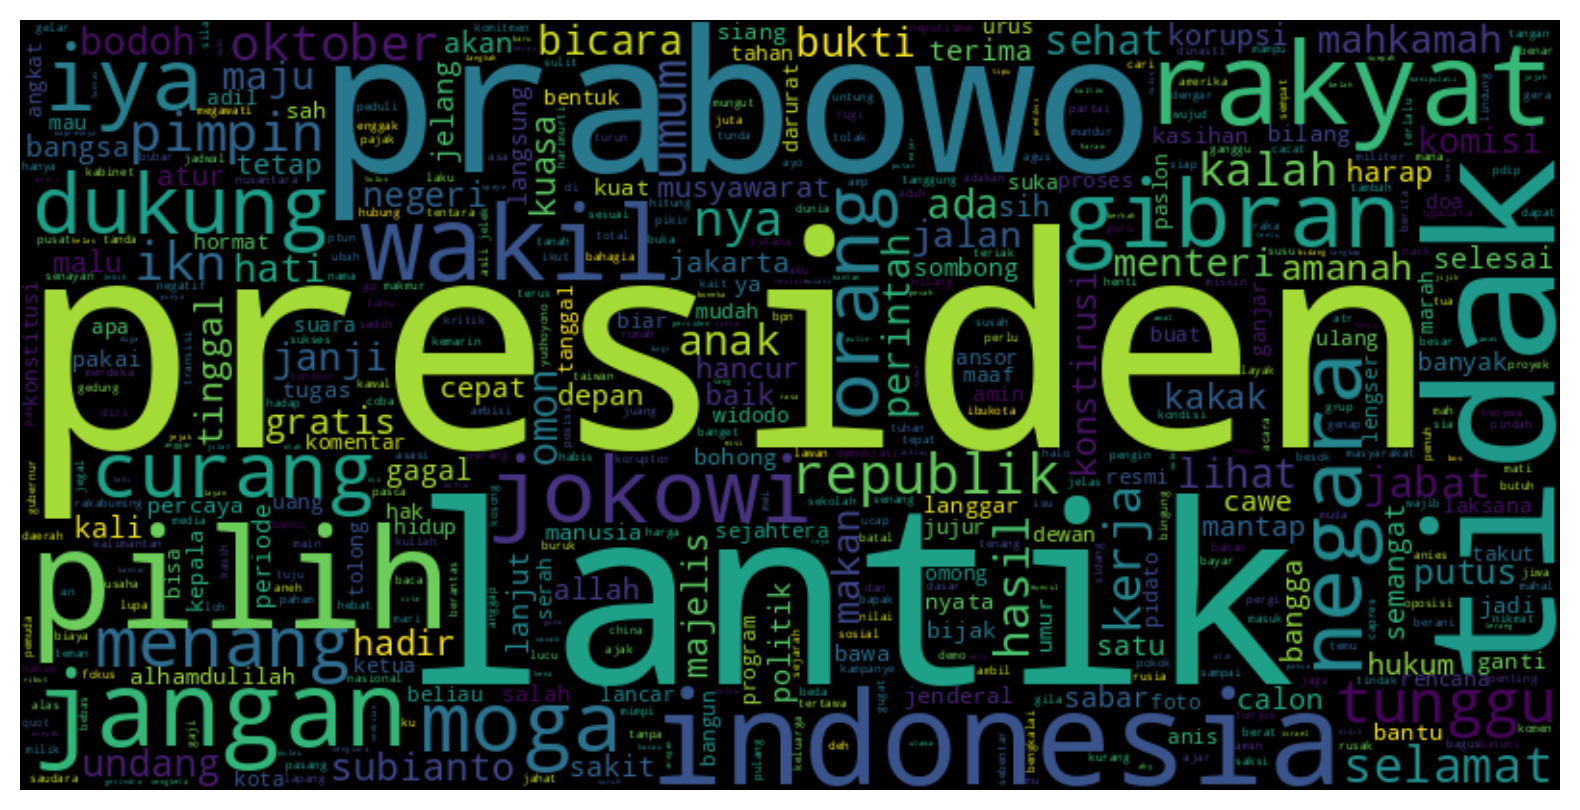

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from collections import Counter

# Gabungkan teks dari kolom 'full_text'
df = ' '.join(data['text_clean'].tolist())

# Tentukan stopwords
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp'])

# Hitung frekuensi kata
word_counts = Counter(df.split())

# Buat WordCloud
wc = WordCloud(stopwords=stopwords, background_color="black", max_words=500, width=800, height=400)
wc.generate_from_frequencies(word_counts)

# Tampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


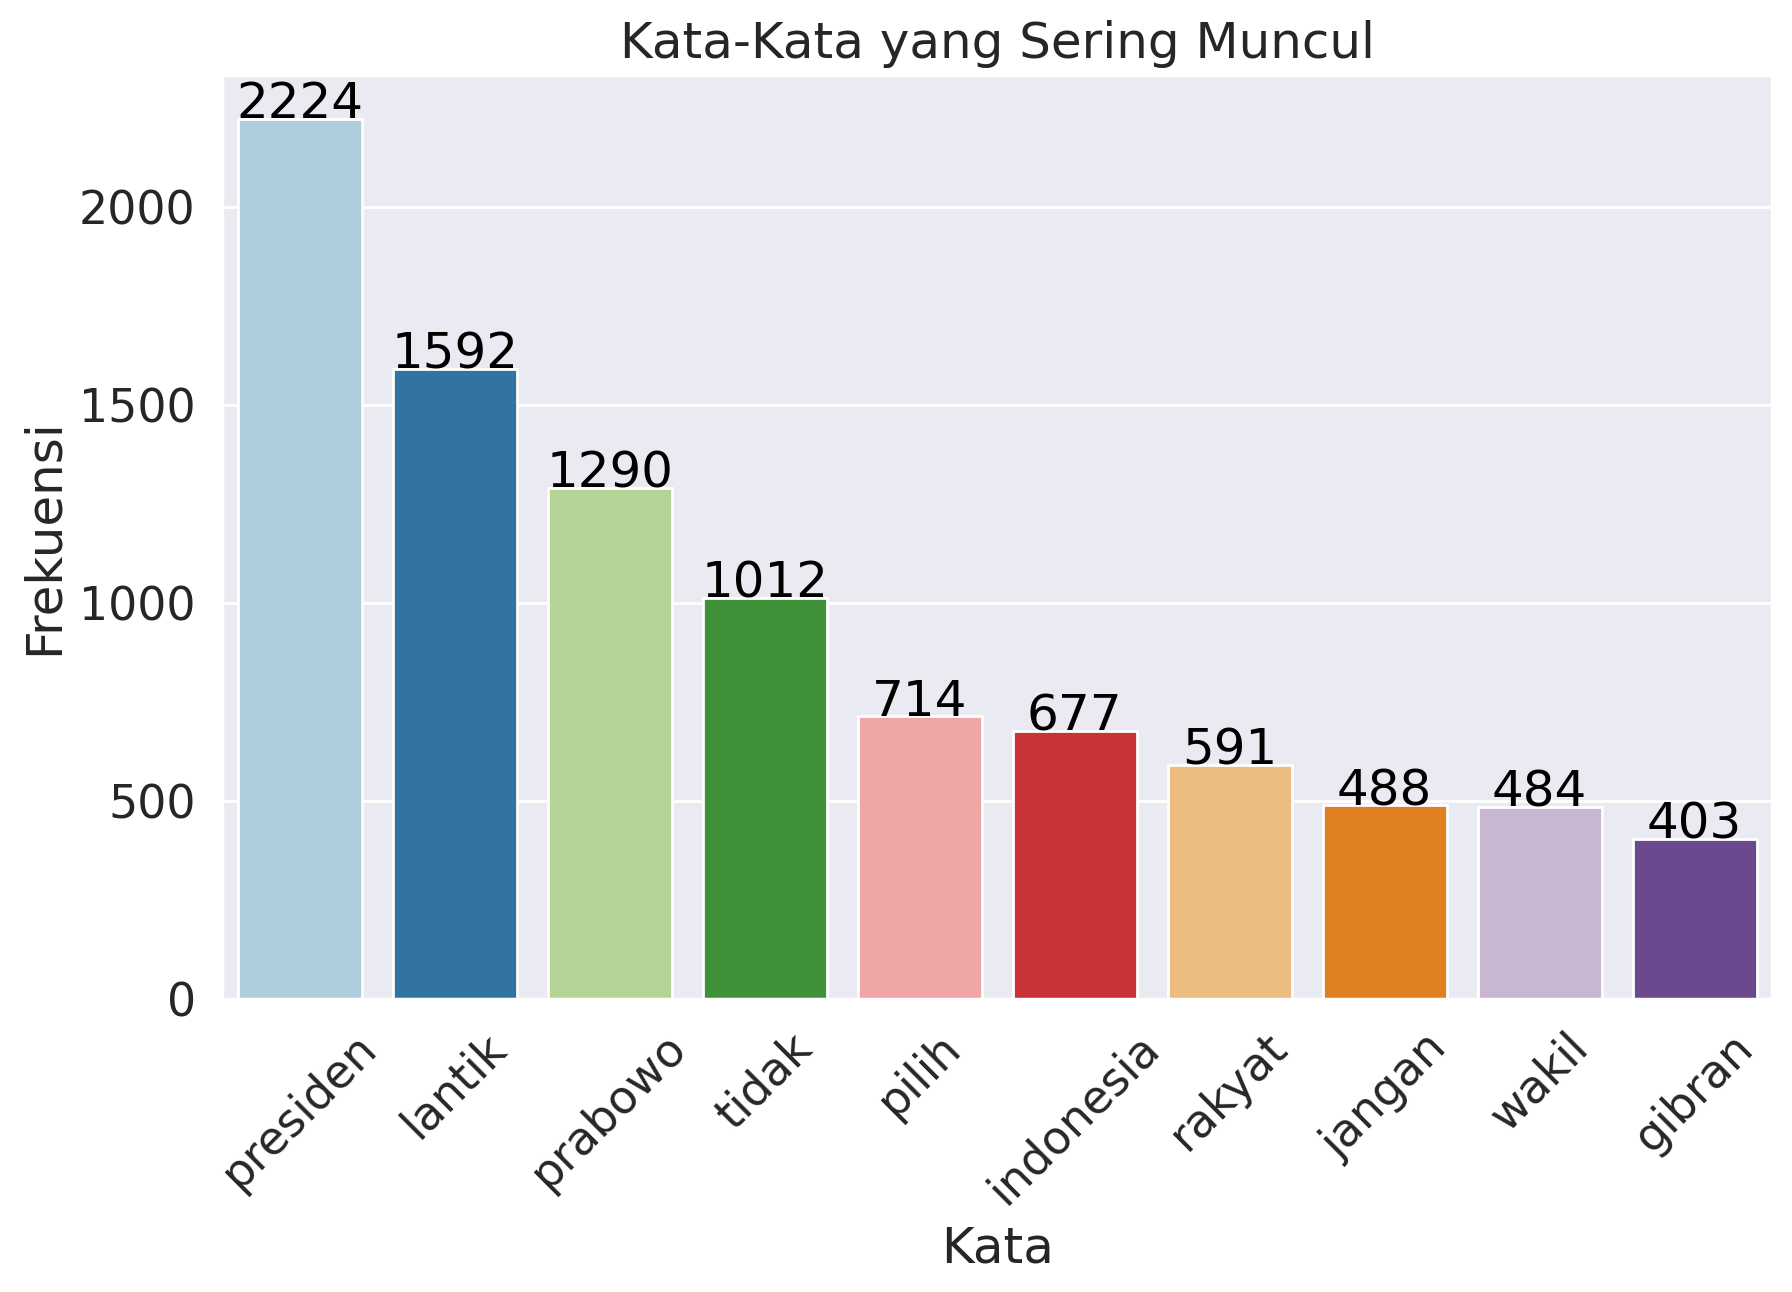

In [ ]:

import pandas as pd
import seaborn as sns
from collections import Counter

# Gabungkan teks dari kolom 'full_text'
text = " ".join(data["text_clean"])

# Tokenisasi teks dan hitung frekuensi kata
tokens = text.split()
word_counts = Counter(tokens)

# Ambil 10 kata yang paling sering muncul
top_words = word_counts.most_common(10)
df_top_words = pd.DataFrame(top_words, columns=['word', 'count'])

# Visualisasi dengan seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_top_words, palette="Paired")
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.title("Kata-Kata yang Sering Muncul")
plt.xticks(rotation=45)

# Tambahkan label frekuensi di atas batang
for index, row in df_top_words.iterrows():
    plt.text(index, row['count'] + 1, row['count'], color='black', ha="center")

plt.show()




#Translate ID to Eng

In [ ]:
import googletrans
from googletrans import Translator

# untuk translate text dari bahasa indonesia ke bahasa inggris

df = pd.DataFrame(data.text_clean)
translator = Translator()
translations = {}
for column in df.columns:
  #unique elements dari kolom
  unique_elements = df[column].unique()
  for element in unique_elements:
    #memasukkan terjemahan ke kamus
    translations[element] = translator.translate(element).text

#memasukkkan hasil translate ke kolom baru
data['translated_text'] = df.replace(translations)

data.head()

,full_text,Case Folding,cleaning,Tokenize,Negation_Handling,Negation_Changes,text_clean,translated_text
0,Menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,"[menyatakan, oposisi, setelah, pelantikan, pre...","[menyatakan, oposisi, setelah, pelantikan, pre...",None,menyatakan oposisi setelah pelantikan presiden...,declared opposition after the inauguration of ...
1,Sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,"[sampai, saat, ini, kondisi, politik, dan, per...","[sampai, saat, ini, kondisi, politik, dan, per...",None,sampai saat ini kondisi politik dan pertumbuha...,"Until now, Indonesia's political conditions an..."
2,MPR lembaga tertinggi Negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,"[mpr, lembaga, tertinggi, negara, ?, berhak, m...","[mpr, lembaga, tertinggi, negara, ?, berhak, m...",None,mpr lembaga tertinggi negara ? berhak menolak ...,"MPR, the highest state institution? has the ri..."
3,Menyalaa Jenderal Kami menantikan Pelantikan P...,menyalaa jenderal kami menantikan pelantikan p...,menyalaa jenderal kami menantikan pelantikan p...,"[menyalaa, jenderal, kami, menantikan, pelanti...","[menyalaa, jenderal, kami, menantikan, pelanti...",None,menyalaa jenderal kami menantikan pelantikan p...,Our generals are looking forward to the inaugu...
4,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,"[pelantikan, presiden, baru, kalo, ada, kebija...","[pelantikan, presiden, baru, kalo, ada, kebija...",None,pelantikan presiden baru kalo ada kebijakannya...,"The inauguration of a new president, if there ..."


#Menyimpan preprocessing

In [ ]:
#  Menyimpan Hasil Preprocessing
data.to_csv('Hasil-Preprocessing-1.csv', index=False)

#LABELING MENGGUNAKAN Flair

In [ ]:
#read dataset
data = pd.read_csv('/content/Hasil-Preprocessing-1.csv', delimiter=',')
data

,full_text,Case Folding,cleaning,Tokenize,Negation_Handling,Negation_Changes,text_clean,translated_text
0,Menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,"['menyatakan', 'oposisi', 'setelah', 'pelantik...","['menyatakan', 'oposisi', 'setelah', 'pelantik...",NaN,menyatakan oposisi setelah pelantikan presiden...,declared opposition after the inauguration of ...
1,Sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,"['sampai', 'saat', 'ini', 'kondisi', 'politik'...","['sampai', 'saat', 'ini', 'kondisi', 'politik'...",NaN,sampai saat ini kondisi politik dan pertumbuha...,"Until now, Indonesia's political conditions an..."
2,MPR lembaga tertinggi Negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,"['mpr', 'lembaga', 'tertinggi', 'negara', '?',...","['mpr', 'lembaga', 'tertinggi', 'negara', '?',...",NaN,mpr lembaga tertinggi negara ? berhak menolak ...,"MPR, the highest state institution? has the ri..."
3,Menyalaa Jenderal Kami menantikan Pelantikan P...,menyalaa jenderal kami menantikan pelantikan p...,menyalaa jenderal kami menantikan pelantikan p...,"['menyalaa', 'jenderal', 'kami', 'menantikan',...","['menyalaa', 'jenderal', 'kami', 'menantikan',...",NaN,menyalaa jenderal kami menantikan pelantikan p...,Our generals are looking forward to the inaugu...
4,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,"['pelantikan', 'presiden', 'baru', 'kalo', 'ad...","['pelantikan', 'presiden', 'baru', 'kalo', 'ad...",NaN,pelantikan presiden baru kalo ada kebijakannya...,"The inauguration of a new president, if there ..."
...,...,...,...,...,...,...,...,...
5278,udh ada pengumuman gitu.????apa jangan jangan ...,udh ada pengumuman gitu.????apa jangan jangan ...,udh ada pengumuman gitu ?apa jangan jangan ten...,"['udh', 'ada', 'pengumuman', 'gitu', '?', 'apa...","['udh', 'ada', 'pengumuman', 'gitu', '?', 'apa...","[(['jangan', 'jangan'], 'jangan_jangan'), (['j...",udh ada pengumuman gitu ? apa jangan_jangan te...,Has there been an announcement like that? Coul...
5279,Semoga dimudahkan dan amanah ya pak?,semoga dimudahkan dan amanah ya pak?,semoga dimudahkan dan amanah ya pak?,"['semoga', 'dimudahkan', 'dan', 'amanah', 'ya'...","['semoga', 'dimudahkan', 'dan', 'amanah', 'ya'...",NaN,semoga dimudahkan dan amanah ya pak ?,"I hope it will be easy and reliable, sir?"
5280,Gila ngeliat muka prabowo setenang itu,gila ngeliat muka prabowo setenang itu,gila ngeliat muka prabowo setenang itu,"['gila', 'ngeliat', 'muka', 'prabowo', 'setena...","['gila', 'ngeliat', 'muka', 'prabowo', 'setena...",NaN,gila ngeliat muka prabowo setenang itu,It's crazy to see Prabowo's face that calm
5281,PERIHATIN. PEMILU PENUH KECURANGAN.,perihatin. pemilu penuh kecurangan.,perihatin pemilu penuh kecurangan,"['perihatin', 'pemilu', 'penuh', 'kecurangan']","['perihatin', 'pemilu', 'penuh', 'kecurangan']",NaN,perihatin pemilu penuh kecurangan,concern the election is full of fraud


In [ ]:
# Checking if the dataset has a value of Null/NaN
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]
rows_with_NaN

# Remove data that have NAN value in column text_clean
data.dropna(subset=['text_clean'], inplace = True)

# mereset indeks ketika data dengan nilai NAN dihapus agar penomoran indeks sesuai
data = data.reset_index(drop = True)
data

,full_text,Case Folding,cleaning,Tokenize,Negation_Handling,Negation_Changes,text_clean,translated_text
0,Menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,"['menyatakan', 'oposisi', 'setelah', 'pelantik...","['menyatakan', 'oposisi', 'setelah', 'pelantik...",NaN,menyatakan oposisi setelah pelantikan presiden...,declared opposition after the inauguration of ...
1,Sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,"['sampai', 'saat', 'ini', 'kondisi', 'politik'...","['sampai', 'saat', 'ini', 'kondisi', 'politik'...",NaN,sampai saat ini kondisi politik dan pertumbuha...,"Until now, Indonesia's political conditions an..."
2,MPR lembaga tertinggi Negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,"['mpr', 'lembaga', 'tertinggi', 'negara', '?',...","['mpr', 'lembaga', 'tertinggi', 'negara', '?',...",NaN,mpr lembaga tertinggi negara ? berhak menolak ...,"MPR, the highest state institution? has the ri..."
3,Menyalaa Jenderal Kami menantikan Pelantikan P...,menyalaa jenderal kami menantikan pelantikan p...,menyalaa jenderal kami menantikan pelantikan p...,"['menyalaa', 'jenderal', 'kami', 'menantikan',...","['menyalaa', 'jenderal', 'kami', 'menantikan',...",NaN,menyalaa jenderal kami menantikan pelantikan p...,Our generals are looking forward to the inaugu...
4,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,"['pelantikan', 'presiden', 'baru', 'kalo', 'ad...","['pelantikan', 'presiden', 'baru', 'kalo', 'ad...",NaN,pelantikan presiden baru kalo ada kebijakannya...,"The inauguration of a new president, if there ..."
...,...,...,...,...,...,...,...,...
5278,udh ada pengumuman gitu.????apa jangan jangan ...,udh ada pengumuman gitu.????apa jangan jangan ...,udh ada pengumuman gitu ?apa jangan jangan ten...,"['udh', 'ada', 'pengumuman', 'gitu', '?', 'apa...","['udh', 'ada', 'pengumuman', 'gitu', '?', 'apa...","[(['jangan', 'jangan'], 'jangan_jangan'), (['j...",udh ada pengumuman gitu ? apa jangan_jangan te...,Has there been an announcement like that? Coul...
5279,Semoga dimudahkan dan amanah ya pak?,semoga dimudahkan dan amanah ya pak?,semoga dimudahkan dan amanah ya pak?,"['semoga', 'dimudahkan', 'dan', 'amanah', 'ya'...","['semoga', 'dimudahkan', 'dan', 'amanah', 'ya'...",NaN,semoga dimudahkan dan amanah ya pak ?,"I hope it will be easy and reliable, sir?"
5280,Gila ngeliat muka prabowo setenang itu,gila ngeliat muka prabowo setenang itu,gila ngeliat muka prabowo setenang itu,"['gila', 'ngeliat', 'muka', 'prabowo', 'setena...","['gila', 'ngeliat', 'muka', 'prabowo', 'setena...",NaN,gila ngeliat muka prabowo setenang itu,It's crazy to see Prabowo's face that calm
5281,PERIHATIN. PEMILU PENUH KECURANGAN.,perihatin. pemilu penuh kecurangan.,perihatin pemilu penuh kecurangan,"['perihatin', 'pemilu', 'penuh', 'kecurangan']","['perihatin', 'pemilu', 'penuh', 'kecurangan']",NaN,perihatin pemilu penuh kecurangan,concern the election is full of fraud


In [ ]:
!pip install flair
from flair.models import TextClassifier
from flair.data import Sentence

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.2 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=39e123cc93f0d7d4065d9e023663d55bac3db72303179793c1f426795a8cbb1d
  Stored in directory: /root/.cach

In [ ]:
# Load English sentiment classifier dari Flair
classifier = TextClassifier.load('en-sentiment')

data['translated_text'] = data['translated_text'].fillna('')

missing_values = data.isnull().sum()
print(missing_values)

# Definisikan fungsi untuk memprediksi sentimen
def predict_sentiment(text):
    sentence = Sentence(text)
    classifier.predict(sentence)
    if len(sentence.labels) > 0:
        label = sentence.labels[0]
        return label.score, label.value
    else:
        return 0.0, 'NEUTRAL'

# Terapkan fungsi predict_sentiment ke kolom 'translated_text' pada dataset
scores = []
sentiments = []

for text in data['translated_text']:
    score, sentiment = predict_sentiment(text)
    scores.append(score)
    if sentiment == 'POSITIVE':
        sentiments.append('positif')
    elif sentiment == 'NEGATIVE':
        sentiments.append('negatif')
    else:
        sentiments.append('netral')

# Tambahkan skor dan sentimen ke dataframe
data['compound_score'] = scores
data['sentimen'] = sentiments

2024-10-03 21:56:21,006 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp4rnzv6vw


100%|██████████| 253M/253M [00:17<00:00, 15.0MB/s]

2024-10-03 21:56:39,221 copying /tmp/tmp4rnzv6vw to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2024-10-03 21:56:40,102 removing temp file /tmp/tmp4rnzv6vw


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

full_text               0
Case Folding            0
cleaning                0
Tokenize                0
Negation_Handling       0
Negation_Changes     4245
text_clean              0
translated_text         0
dtype: int64


In [ ]:
#menghitung jumlah tiap sentimen
data['sentimen'].value_counts()

,count
sentimen,
negatif,2763
positif,2520


Text(0.5, 1.0, 'Presentase Labeling Flair')

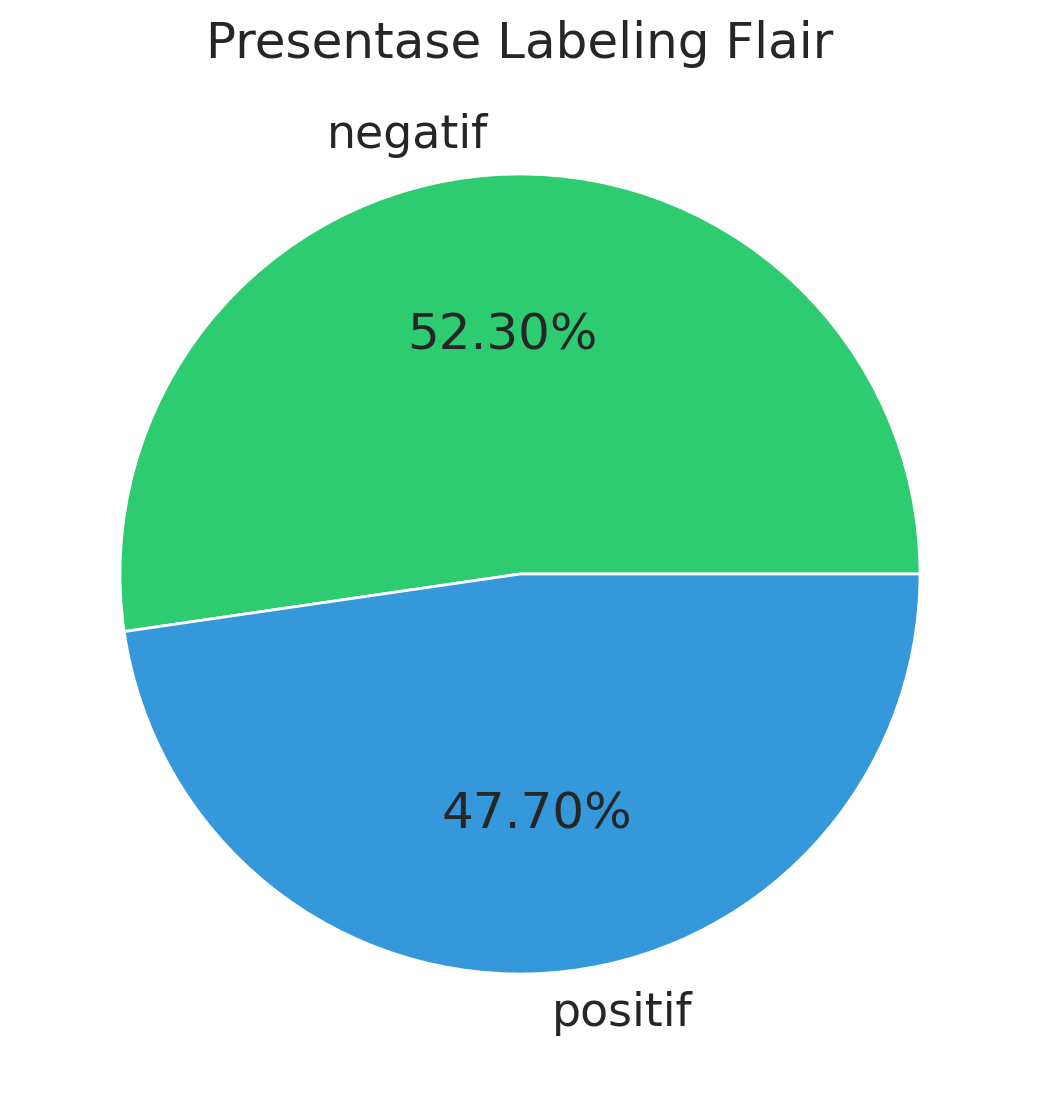

In [ ]:
diagram = data['sentimen'].value_counts().rename_axis('nilai_sentimen').reset_index(name='jumlah')
label = diagram.nilai_sentimen
nilai = diagram.jumlah

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis = ('equal')


ax.pie(nilai, labels = label, autopct='%1.2f%%' )
ax.set_title("Presentase Labeling Flair")

FINISH LABELING FLAIR


In [ ]:
data.to_csv('labeling_data_flair.csv', encoding='utf8', index=False)

In [ ]:
#  Menyimpan Hasil Preprocessing
data.to_csv('Preprocessing_dan_Labeling_flair.csv', index=False)

#  Convert String To Integer Based On Column "sentimen"

In [ ]:
# Convert String To Integer Based On Column "sentimen"
def string_to_integer(sentimen):
    if sentimen == 'negatif':
      return 0
    elif sentimen == 'positif':
      return 1
    else:
      return 2

data['sentiment'] = data.sentimen.apply(string_to_integer)
data

,full_text,Case Folding,cleaning,Tokenize,Negation_Handling,Negation_Changes,text_clean,translated_text,compound_score,sentimen,sentiment
0,Menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,"['menyatakan', 'oposisi', 'setelah', 'pelantik...","['menyatakan', 'oposisi', 'setelah', 'pelantik...",NaN,menyatakan oposisi setelah pelantikan presiden...,declared opposition after the inauguration of ...,0.984839,negatif,0
1,Sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,"['sampai', 'saat', 'ini', 'kondisi', 'politik'...","['sampai', 'saat', 'ini', 'kondisi', 'politik'...",NaN,sampai saat ini kondisi politik dan pertumbuha...,"Until now, Indonesia's political conditions an...",0.937155,positif,1
2,MPR lembaga tertinggi Negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,"['mpr', 'lembaga', 'tertinggi', 'negara', '?',...","['mpr', 'lembaga', 'tertinggi', 'negara', '?',...",NaN,mpr lembaga tertinggi negara ? berhak menolak ...,"MPR, the highest state institution? has the ri...",0.844703,negatif,0
3,Menyalaa Jenderal Kami menantikan Pelantikan P...,menyalaa jenderal kami menantikan pelantikan p...,menyalaa jenderal kami menantikan pelantikan p...,"['menyalaa', 'jenderal', 'kami', 'menantikan',...","['menyalaa', 'jenderal', 'kami', 'menantikan',...",NaN,menyalaa jenderal kami menantikan pelantikan p...,Our generals are looking forward to the inaugu...,0.996813,positif,1
4,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,"['pelantikan', 'presiden', 'baru', 'kalo', 'ad...","['pelantikan', 'presiden', 'baru', 'kalo', 'ad...",NaN,pelantikan presiden baru kalo ada kebijakannya...,"The inauguration of a new president, if there ...",0.995884,positif,1
...,...,...,...,...,...,...,...,...,...,...,...
5278,udh ada pengumuman gitu.????apa jangan jangan ...,udh ada pengumuman gitu.????apa jangan jangan ...,udh ada pengumuman gitu ?apa jangan jangan ten...,"['udh', 'ada', 'pengumuman', 'gitu', '?', 'apa...","['udh', 'ada', 'pengumuman', 'gitu', '?', 'apa...","[(['jangan', 'jangan'], 'jangan_jangan'), (['j...",udh ada pengumuman gitu ? apa jangan_jangan te...,Has there been an announcement like that? Coul...,0.501519,negatif,0
5279,Semoga dimudahkan dan amanah ya pak?,semoga dimudahkan dan amanah ya pak?,semoga dimudahkan dan amanah ya pak?,"['semoga', 'dimudahkan', 'dan', 'amanah', 'ya'...","['semoga', 'dimudahkan', 'dan', 'amanah', 'ya'...",NaN,semoga dimudahkan dan amanah ya pak ?,"I hope it will be easy and reliable, sir?",0.997554,positif,1
5280,Gila ngeliat muka prabowo setenang itu,gila ngeliat muka prabowo setenang itu,gila ngeliat muka prabowo setenang itu,"['gila', 'ngeliat', 'muka', 'prabowo', 'setena...","['gila', 'ngeliat', 'muka', 'prabowo', 'setena...",NaN,gila ngeliat muka prabowo setenang itu,It's crazy to see Prabowo's face that calm,0.999618,positif,1
5281,PERIHATIN. PEMILU PENUH KECURANGAN.,perihatin. pemilu penuh kecurangan.,perihatin pemilu penuh kecurangan,"['perihatin', 'pemilu', 'penuh', 'kecurangan']","['perihatin', 'pemilu', 'penuh', 'kecurangan']",NaN,perihatin pemilu penuh kecurangan,concern the election is full of fraud,0.997850,negatif,0


# Menyimpan Dataset setelah Preprocessing

In [ ]:
# Menyimpan dataset
data.to_csv('dataset-preprocessing-Final.csv', index=False)

# Exploratory Data Analysis

In [ ]:
# Read result of final dataset
data = pd.read_csv("/content/dataset-preprocessing-Final.csv")
data

,full_text,Case Folding,cleaning,Tokenize,Negation_Handling,Negation_Changes,text_clean,translated_text,compound_score,sentimen,sentiment
0,Menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,menyatakan oposisi setelah pelantikan presiden...,"['menyatakan', 'oposisi', 'setelah', 'pelantik...","['menyatakan', 'oposisi', 'setelah', 'pelantik...",NaN,menyatakan oposisi setelah pelantikan presiden...,declared opposition after the inauguration of ...,0.984839,negatif,0
1,Sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,sampai saat ini kondisi politik dan pertumbuha...,"['sampai', 'saat', 'ini', 'kondisi', 'politik'...","['sampai', 'saat', 'ini', 'kondisi', 'politik'...",NaN,sampai saat ini kondisi politik dan pertumbuha...,"Until now, Indonesia's political conditions an...",0.937155,positif,1
2,MPR lembaga tertinggi Negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,mpr lembaga tertinggi negara ?berhak menolak p...,"['mpr', 'lembaga', 'tertinggi', 'negara', '?',...","['mpr', 'lembaga', 'tertinggi', 'negara', '?',...",NaN,mpr lembaga tertinggi negara ? berhak menolak ...,"MPR, the highest state institution? has the ri...",0.844703,negatif,0
3,Menyalaa Jenderal Kami menantikan Pelantikan P...,menyalaa jenderal kami menantikan pelantikan p...,menyalaa jenderal kami menantikan pelantikan p...,"['menyalaa', 'jenderal', 'kami', 'menantikan',...","['menyalaa', 'jenderal', 'kami', 'menantikan',...",NaN,menyalaa jenderal kami menantikan pelantikan p...,Our generals are looking forward to the inaugu...,0.996813,positif,1
4,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,pelantikan presiden baru kalo ada kebijakannya...,"['pelantikan', 'presiden', 'baru', 'kalo', 'ad...","['pelantikan', 'presiden', 'baru', 'kalo', 'ad...",NaN,pelantikan presiden baru kalo ada kebijakannya...,"The inauguration of a new president, if there ...",0.995884,positif,1
...,...,...,...,...,...,...,...,...,...,...,...
5278,udh ada pengumuman gitu.????apa jangan jangan ...,udh ada pengumuman gitu.????apa jangan jangan ...,udh ada pengumuman gitu ?apa jangan jangan ten...,"['udh', 'ada', 'pengumuman', 'gitu', '?', 'apa...","['udh', 'ada', 'pengumuman', 'gitu', '?', 'apa...","[(['jangan', 'jangan'], 'jangan_jangan'), (['j...",udh ada pengumuman gitu ? apa jangan_jangan te...,Has there been an announcement like that? Coul...,0.501519,negatif,0
5279,Semoga dimudahkan dan amanah ya pak?,semoga dimudahkan dan amanah ya pak?,semoga dimudahkan dan amanah ya pak?,"['semoga', 'dimudahkan', 'dan', 'amanah', 'ya'...","['semoga', 'dimudahkan', 'dan', 'amanah', 'ya'...",NaN,semoga dimudahkan dan amanah ya pak ?,"I hope it will be easy and reliable, sir?",0.997554,positif,1
5280,Gila ngeliat muka prabowo setenang itu,gila ngeliat muka prabowo setenang itu,gila ngeliat muka prabowo setenang itu,"['gila', 'ngeliat', 'muka', 'prabowo', 'setena...","['gila', 'ngeliat', 'muka', 'prabowo', 'setena...",NaN,gila ngeliat muka prabowo setenang itu,It's crazy to see Prabowo's face that calm,0.999618,positif,1
5281,PERIHATIN. PEMILU PENUH KECURANGAN.,perihatin. pemilu penuh kecurangan.,perihatin pemilu penuh kecurangan,"['perihatin', 'pemilu', 'penuh', 'kecurangan']","['perihatin', 'pemilu', 'penuh', 'kecurangan']",NaN,perihatin pemilu penuh kecurangan,concern the election is full of fraud,0.997850,negatif,0


In [ ]:
# Convert String To Integer Based On Column "sentimen"
def string_to_integer(sentimen):
    if sentimen == 'negatif':
      return 0
    elif sentimen == 'positif':
      return 1
    else:
      return 2

data['sentiment'] = data.sentimen.apply(string_to_integer)


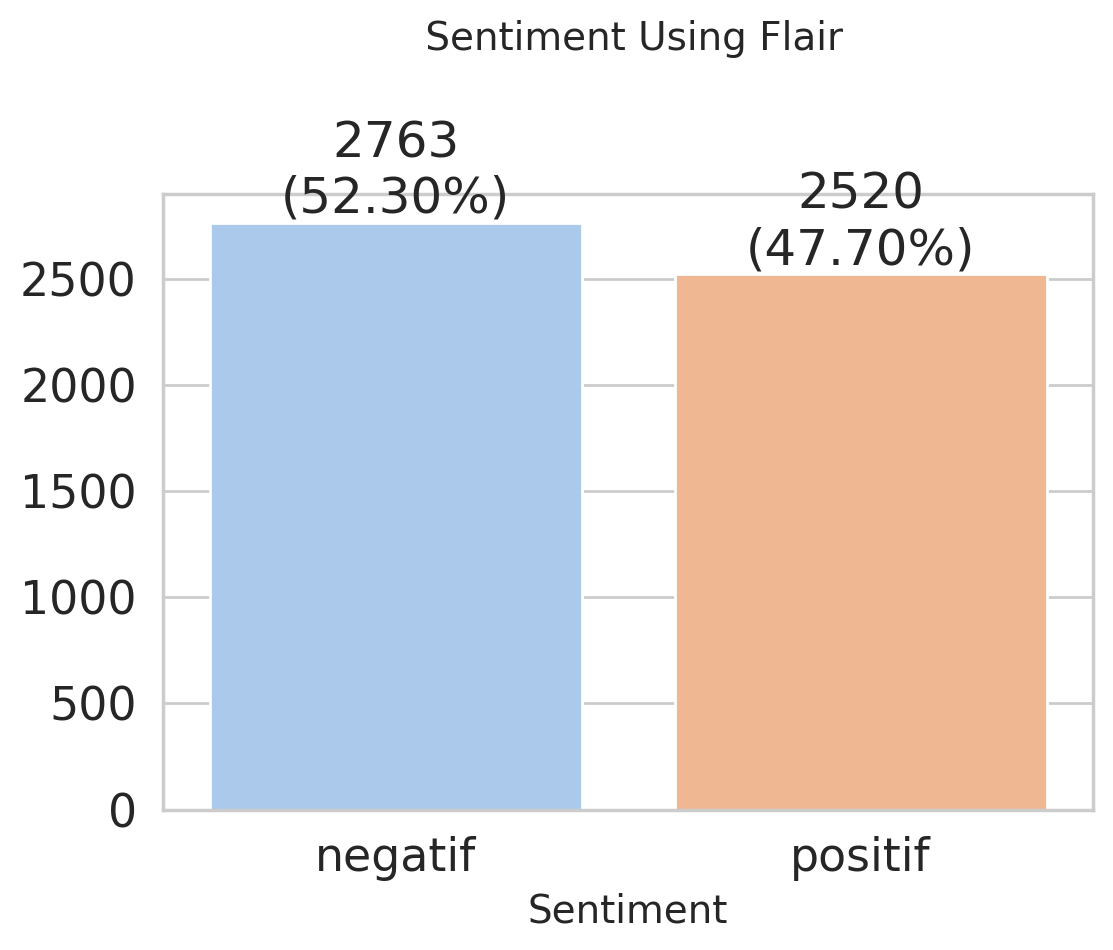

In [ ]:
sentiment_count = data['sentimen'].value_counts()

# Set style plot seaborn
sns.set_style('whitegrid')

# Membuat figure dan axes
fig, ax = plt.subplots(figsize=(6, 4))

# Membuat barplot
sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel', ax=ax)

# Menambahkan judul dan label sumbu
plt.title(' Sentiment Using Flair\n\n', fontsize=14, pad=20)
plt.xlabel('Sentiment', fontsize=14)
# plt.ylabel('Count', fontsize=12)

# Menghitung total sentimen
total = len(data['sentiment'])

# Menambahkan anotasi pada setiap bar
for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

# Menampilkan plot
plt.show()

In [ ]:
# menyisakan kolom yang diperlukan
data = data[['text_clean', 'sentiment']]
data

,text_clean,sentiment
0,menyatakan oposisi setelah pelantikan presiden...,0
1,sampai saat ini kondisi politik dan pertumbuha...,1
2,mpr lembaga tertinggi negara ? berhak menolak ...,0
3,menyalaa jenderal kami menantikan pelantikan p...,1
4,pelantikan presiden baru kalo ada kebijakannya...,1
...,...,...
5278,udh ada pengumuman gitu ? apa jangan_jangan te...,0
5279,semoga dimudahkan dan amanah ya pak ?,1
5280,gila ngeliat muka prabowo setenang itu,1
5281,perihatin pemilu penuh kecurangan,0


# Handling Missing Value

In [ ]:
# Checking if the dataset has a value of Null/NaN
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]
rows_with_NaN

# Remove data that have NAN value in column text_clean
data.dropna(subset=['text_clean'], inplace = True)

# mereset indeks ketika data dengan nilai NAN dihapus agar penomoran indeks sesuai
data = data.reset_index(drop = True)
data

,text_clean,sentiment
0,menyatakan oposisi setelah pelantikan presiden...,0
1,sampai saat ini kondisi politik dan pertumbuha...,1
2,mpr lembaga tertinggi negara ? berhak menolak ...,0
3,menyalaa jenderal kami menantikan pelantikan p...,1
4,pelantikan presiden baru kalo ada kebijakannya...,1
...,...,...
5278,udh ada pengumuman gitu ? apa jangan_jangan te...,0
5279,semoga dimudahkan dan amanah ya pak ?,1
5280,gila ngeliat muka prabowo setenang itu,1
5281,perihatin pemilu penuh kecurangan,0


In [ ]:
def count_words(text):
    return len(text.split())

# Menghitung jumlah kata dari setiap kalimat
word_counts = data['text_clean'].apply(count_words)

# Mendapatkan kalimat terpanjang dan jumlah katanya
longest_sentence = data['text_clean'].iloc[word_counts.idxmax()]
longest_word_count = word_counts.max()

# Menampilkan kalimat terpanjang dan jumlah katanya

print("Jumlah Kata Terbanyak:", longest_word_count)

Jumlah Kata Terbanyak: 54


# Prepare For BERT Sentiment Analysis

##Tokenize Dataset

In [ ]:
# Dict mapping
label_to_num = {'negatif': 0, 'positif': 1, 'netral':2}
num_to_label = {0: 'negatif', 1: 'positif', 2: 'netral'}

In [ ]:
print('Loading BERT tokenizer...')
# Load BertTokenizer
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

## Membagi Dataset menjadi Training,Validation,Testing

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Asumsikan 'data' adalah DataFrame Anda yang sudah ada

# Langkah 1: Pengacakan data (jika belum dilakukan)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Langkah 2: Stratified Sampling untuk membagi dataset
X = data['text_clean']
y = data['sentiment']

# Pertama, pisahkan 10% untuk test set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Kemudian, dari sisa 90%, ambil 8/9 (sekitar 88.89%) untuk train set
# Ini akan menghasilkan 80% dari total data untuk train set
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=1/9, stratify=y_trainval, random_state=42
)

# Membuat DataFrame untuk setiap set data
train_data = pd.DataFrame({'text_clean': X_train, 'sentiment': y_train})
val_data = pd.DataFrame({'text_clean': X_val, 'sentiment': y_val})
test_data = pd.DataFrame({'text_clean': X_test, 'sentiment': y_test})

# Menampilkan jumlah dan persentase data
total_data = len(data)
print(f"Jumlah data train: {len(train_data)} ({len(train_data)/total_data:.2%})")
print(f"Jumlah data val: {len(val_data)} ({len(val_data)/total_data:.2%})")
print(f"Jumlah data test: {len(test_data)} ({len(test_data)/total_data:.2%})")

# Ekstraksi sentences dan labels
train_sentences = train_data['text_clean'].values
train_labels = train_data['sentiment'].values

val_sentences = val_data['text_clean'].values
val_labels = val_data['sentiment'].values

test_sentences = test_data['text_clean'].values
test_labels = test_data['sentiment'].values

# Verifikasi distribusi sentimen
print("\nDistribusi Sentimen:")
print("Train:", train_data['sentiment'].value_counts(normalize=True))
print("Validation:", val_data['sentiment'].value_counts(normalize=True))
print("Test:", test_data['sentiment'].value_counts(normalize=True))

# Menampilkan jumlah dan persentase data
total_data = len(data)
print(f"Jumlah data train: {len(train_data)} ({len(train_data)/total_data:.1%})")
print(f"Jumlah data val: {len(val_data)} ({len(val_data)/total_data:.1%})")
print(f"Jumlah data test: {len(test_data)} ({len(test_data)/total_data:.1%})")

# Verifikasi distribusi sentimen
print("\nDistribusi Sentimen:")
print("Train:\n", train_data['sentiment'].value_counts().to_frame(name='Jumlah').assign(
    Persentase=lambda x: (x['Jumlah'] / len(train_data) * 100).round(2)))
print("Validation:\n", val_data['sentiment'].value_counts().to_frame(name='Jumlah').assign(
    Persentase=lambda x: (x['Jumlah'] / len(val_data) * 100).round(2)))
print("Test:\n", test_data['sentiment'].value_counts().to_frame(name='Jumlah').assign(
    Persentase=lambda x: (x['Jumlah'] / len(test_data) * 100).round(2)))

Jumlah data train: 4225 (79.97%)
Jumlah data val: 529 (10.01%)
Jumlah data test: 529 (10.01%)

Distribusi Sentimen:
Train: sentiment
0    0.52284
1    0.47716
Name: proportion, dtype: float64
Validation: sentiment
0    0.523629
1    0.476371
Name: proportion, dtype: float64
Test: sentiment
0    0.523629
1    0.476371
Name: proportion, dtype: float64
Jumlah data train: 4225 (80.0%)
Jumlah data val: 529 (10.0%)
Jumlah data test: 529 (10.0%)

Distribusi Sentimen:
Train:
            Jumlah  Persentase
sentiment                    
0            2209       52.28
1            2016       47.72
Validation:
            Jumlah  Persentase
sentiment                    
0             277       52.36
1             252       47.64
Test:
            Jumlah  Persentase
sentiment                    
0             277       52.36
1             252       47.64


In [ ]:
#TRAIN DATA model BERT

# Menguraikan semua kalimat dan memetakan token-token tersebut ke dalam IDs.
input_ids_train = []
attention_masks_train = []

# kalimat dalam data pelatihan
for sent in train_sentences:
    if pd.notnull(sent):  # cek apakah kalimat tidak bernilai null
        encoded_dict = tokenizer.encode_plus(
            sent,                        # Sentence to encode.
            add_special_tokens=True,     # menambah '[CLS]' dan '[SEP]'
            max_length=64,              # Pad & truncate all sentences.
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,  # membuat attention masks.
            return_tensors='pt'          # mengembalikan PyTorch tensors.
        )
        # Lanjutkan dengan pemrosesan selanjutnya setelah encoding
    else:
        print("Found 'nan' value in the dataset. Skipping this sentence.")

    input_ids_train.append(encoded_dict['input_ids'])
    attention_masks_train.append(encoded_dict['attention_mask'])

# menggabungkan menjadi satu tensor besar
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(train_labels)

# Print
print('Original: ', train_sentences[3])
print('Token IDs:', input_ids_train[3])

Original:  harapannya pembelian barang barang kedepannya akan selaras dengan kebutuhan negara bukan kepentingan pribadi
Token IDs: tensor([    2, 17484,  3975,   963,   963, 13276,   150, 15158,    79,  1255,
          664,   531,  3041,  2028,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
# Validation data  model BERT
input_ids_val = []
attention_masks_val = []

# kalimat dalam data val
for sent in val_sentences:
    if pd.notnull(sent):  # cek apakah kalimat tidak bernilai null
        encoded_dict = tokenizer.encode_plus(
            sent,                        # Sentence to encode.
            add_special_tokens=True,     # menambah '[CLS]' dan '[SEP]'
            max_length=64,              # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # membuat attention masks.
            return_tensors='pt',         # mengambalikan PyTorch tensors.
            truncation=True
        )
        # Lanjutkan dengan pemrosesan selanjutnya setelah encoding
    else:
        print("Found 'nan' value in the dataset. Skipping this sentence.")

    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

# menggabungkan menjadi satu tensor besar
input_ids_val = torch.cat(input_ids_val, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
labels_val = torch.tensor(val_labels)


# Print
print('Original: ', val_sentences[2])
print('Token IDs:', input_ids_val[2])

Original:  intinya yg kalah bakal banyak dalil untuk menutupi kekecewaan dan rasa malu mereka karena kalah
Token IDs: tensor([    2,  7004,   741,  3221,  2990,   271,  7933,    90,  7843, 15565,
           41,  1214,  5535,   267,   211,  3221,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
# menggabungkan data input pelatihan dan validasi menjadi objek TensorDataset
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
# menentukan jumlah bacth size
batch_size = 32

# mengambil sampel data pelatihan secara acak/random
train_dataloader = DataLoader(train_dataset,
                              sampler = RandomSampler(train_dataset), # memilih secara acak data latih
                              num_workers=4,
                              batch_size = batch_size # menggunakan batch size yang sudah di inisiasi
                             )

# dataloader validation tidak secara acak
validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),
                                   num_workers=4,
                                   batch_size = batch_size
                                  )

## BertForSequenceClassification

In [ ]:
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
import torch

# Memuat konfigurasi model BERT
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')

# Mengubah parameter dropout
config.hidden_dropout_prob = 0.3  # Probabilitas dropout untuk hidden states
config.attention_probs_dropout_prob = 0.3  # Probabilitas dropout untuk attention

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1', # Menggunakan model bert yang sudah dilatih dan memiliki 12 layer dengan vocab IndoBERT
    num_labels=3,                    # Jumlah label atau kelas yang akan diprediksi
    output_attentions=False,
    output_hidden_states=False,
    ignore_mismatched_sizes=True     # Menambahkan parameter ini
)
bert_model = model.bert

# jalankan model menggunakan GPU
# Memastikan model menggunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if next(model.parameters()).is_cuda:
    print('Model menggunakan GPU.')
else:
    print('Model menggunakan CPU.')

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Model menggunakan GPU.


In [ ]:
# Jumlah layer baru dari 12 ke 6
num_layers_to_keep = 9

# Potong model menjadi jumlah layer yang diinginkan
bert_model.encoder.layer = bert_model.encoder.layer[:num_layers_to_keep]

# Update konfigurasi model
model.config.num_hidden_layers = num_layers_to_keep

# Mengambil semua parameter model dalam bentuk daftar tuple
params = list(model.named_parameters())

# Menampilkan jumlah total parameter yang dinamai dalam model BERT
print(f'Model BERT memiliki {len(params)} parameter yang berbeda.\n')


# Menampilkan jumlah lapisan encoder dalam model BERT
num_layers = model.config.num_hidden_layers
print(f'\nModel BERT sekarang memiliki {num_layers} lapisan encoder.')

Model BERT memiliki 153 parameter yang berbeda.


Model BERT sekarang memiliki 9 lapisan encoder.


## Optimizer & Learning Rate Scheduler


In [ ]:
#  Optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5, eps = 1e-5,weight_decay=0.001)
# jumlah Epochs
epochs = 10

print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs
# Maximum norm for gradient clipping
max_grad_norm = 1.0

# membuat learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # default dari run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 133


In [ ]:
# menghitung akurasi dari prediksi

#menghitung akurasi dari prediksi model
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#mengonversi waktu dalam detik ke format string
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''

    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#  Training and Validation Model BERT

In [ ]:
import time
import numpy as np
import torch

# Lis variabel untuk train dan validation loss, validation accuracy, and timings.
training_stats = []

# waktu pelatihan
total_t0 = time.time()

# Implementing Early Stopping
best_val_loss = float('inf')  # Inisialisasi dengan nilai yang sangat besar
patience = 3  # Jumlah epoch yang harus ditunggu sebelum menghentikan training jika tidak ada perbaikan
trigger_times = 0  # Counter untuk mengecek jika tidak ada perbaikan

# untuk setiap epoch.
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # lama waktu training epoch
    t0 = time.time()

    # Reset total loss untuk setiap epoch.
    total_train_loss = 0
    total_train_correct = 0

    # simpan model ke model train
    model.train()

    # untuk setiap batch dalam training data
    for step, batch in enumerate(train_dataloader):
        # update progress setiap 20 batch
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)   #input IDS
        b_input_mask = batch[1].to(device)  # attention masks
        b_labels = batch[2].to(device)      # labels

        # hapus any previously calculated gradients before performing a backward pass
        model.zero_grad()

        outputs = model(b_input_ids,              #tabahkan   torch.randn(32, 10)
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels)

        loss = outputs[0]
        logits = outputs[1]

        # akumulasi training loss dari seluruh batch
        total_train_loss += loss.item()

        # Menghitung prediksi
        _, predicted_labels = torch.max(logits, 1)
        total_train_correct += (predicted_labels == b_labels).sum().item()

        # backward pass untuk menghitung the gradients.
        loss.backward()


        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # menghitung rata-rata loss over dari seluruh bacth.
    train_loss = total_train_loss / len(train_dataloader)

    # menghitung rata-rata training accuracy
    train_accuracy = total_train_correct / len(train_dataloader.dataset)

    # memastikan berapa lama waktu
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(train_loss))
    print("  Training Accuracy: {0:.2f}".format(train_accuracy))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # mode evaluasi (batchnorm, dropout disable)
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            loss = outputs[0]
            logits = outputs[1]

        # akumulasi validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # menghitung akurasi
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # final accuracy for this validation run.
    val_accuracy = total_eval_accuracy / len(validation_dataloader)

    # menghitung rata rata loss over dari semua batch
    val_loss = total_eval_loss / len(validation_dataloader)

    # memastikan berapa lama waktu
    validation_time = format_time(time.time() - t0)

    print("  Validation accuracy: {0:.2f}".format(val_accuracy))
    print("  Validation Loss: {0:.2f}".format(val_loss))
    print("  Validation took: {:}".format(validation_time))

    # statistik dari setiap epoch
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': train_loss,
            'Validation Loss': val_loss,
            'Training Accuracy': train_accuracy,
            'Validation Accuracy': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    # Early Stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0  # Reset counter jika ada perbaikan
        torch.save(model.state_dict(), 'best_model.pt')  # Simpan model terbaik
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping triggered!')
            break

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 10 ========
Training...
  Batch    20  of    133.    Elapsed: 0:00:06.
  Batch    40  of    133.    Elapsed: 0:00:11.
  Batch    60  of    133.    Elapsed: 0:00:16.
  Batch    80  of    133.    Elapsed: 0:00:21.
  Batch   100  of    133.    Elapsed: 0:00:27.
  Batch   120  of    133.    Elapsed: 0:00:32.

  Average training loss: 0.66
  Training Accuracy: 0.65
  Training epoch took: 0:00:35

Running Validation...
  Validation accuracy: 0.73
  Validation Loss: 0.54
  Validation took: 0:00:02

======== Epoch 2 / 10 ========
Training...
  Batch    20  of    133.    Elapsed: 0:00:05.
  Batch    40  of    133.    Elapsed: 0:00:10.
  Batch    60  of    133.    Elapsed: 0:00:15.
  Batch    80  of    133.    Elapsed: 0:00:20.
  Batch   100  of    133.    Elapsed: 0:00:26.
  Batch   120  of    133.    Elapsed: 0:00:31.

  Average training loss: 0.48
  Training Accuracy: 0.78
  Training epoch took: 0:00:34

Running Validation...
  Validation accuracy: 0.76
  Validation Loss: 

In [ ]:

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,,
1,0.656508,0.537435,0.648284,0.733888,0:00:35,0:00:02
2,0.479070,0.503096,0.775858,0.757569,0:00:34,0:00:02
3,0.395059,0.458203,0.825562,0.790874,0:00:34,0:00:02
4,0.322116,0.476467,0.865325,0.799849,0:00:34,0:00:02
5,0.256492,0.510258,0.896095,0.805363,0:00:34,0:00:02
6,0.199915,0.561316,0.920473,0.803525,0:00:34,0:00:02


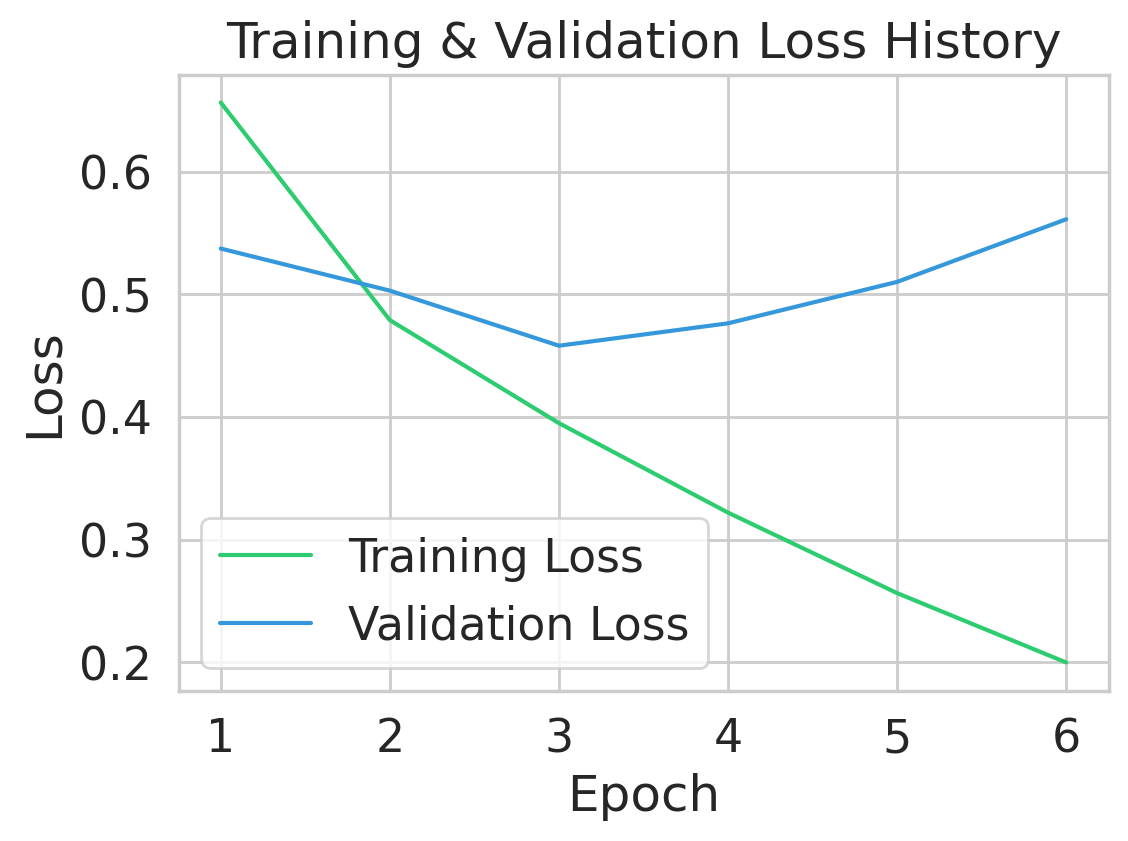

In [ ]:
# Grafik Training & Validation Loss
plt.figure(figsize=(6,4))
plt.plot(df_stats['Training Loss'], label='Training Loss')
plt.plot(df_stats['Validation Loss'], label='Validation Loss')
plt.title('Training & Validation Loss History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

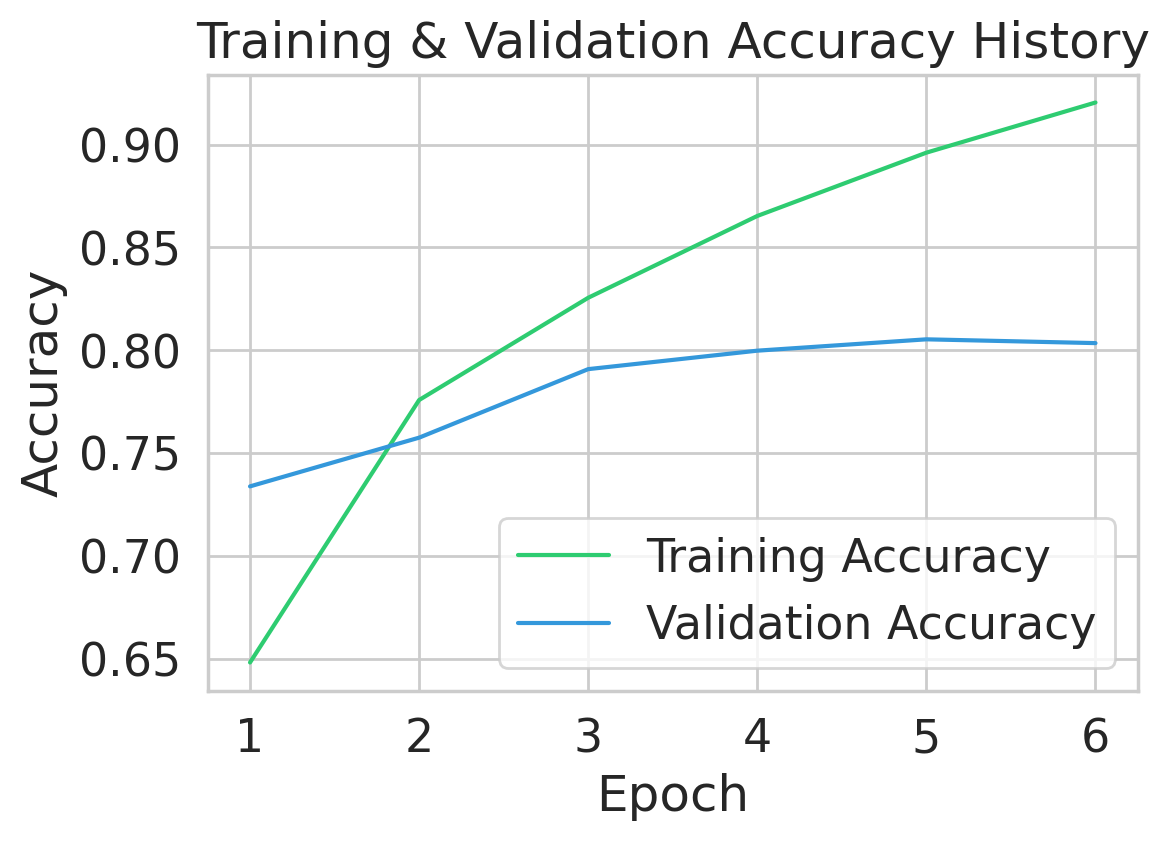

In [ ]:
# # Grafik Training & Validation akurasi
plt.figure(figsize=(6,4))
plt.plot(df_stats['Training Accuracy'], label='Training Accuracy')
plt.plot(df_stats['Validation Accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#Evaluation Model Bert and Prediction New Data

In [ ]:
# Tokenize untuk seluruh kalimat dan map token tersebut ke IDs
input_ids_test = []
attention_masks_test = []

#
for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(sent,                           # kalimat.
                                         add_special_tokens = True,      # tambah '[CLS]' dan '[SEP]'
                                         max_length = 64,               # Pad & truncate all sentences.
                                         pad_to_max_length = True,
                                         return_attention_mask = True,   # buat attention mask
                                         return_tensors = 'pt',          # Return pytorch tensors.
                                         truncation = True
                                        )


    input_ids_test.append(encoded_dict['input_ids'])


    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(test_labels)

# set batch size
batch_size = 32

# Buat Rataloader.
prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediksi test
print(f'Predicting labels for {len(input_ids_test):,} test sentences...')

model.eval()

# Tracking variables
predictions, true_labels = [], []

# Prediksi
for batch in prediction_dataloader:
    # Move tensors to the device (GPU or CPU)
    b_input_ids, b_input_mask, b_labels = (t.to(device) for t in batch)

    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU and convert to numpy
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()

    # Append predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE.')

Predicting labels for 529 test sentences...
DONE.


In [ ]:
# menghitung jumlah sampel pengujian
flat_pred = []
flat_true = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        flat_pred.append(predictions[i][j])
        flat_true.append(true_labels[i][j])

print(f"Jumlah sampel pengujian: {len(flat_pred)}")

Jumlah sampel pengujian: 529


In [ ]:
# Classification report
class_names = ['Negatif', 'Positif']
print(classification_report(flat_true, np.argmax(flat_pred, axis=1), digits=4, target_names=class_names))

              precision    recall  f1-score   support

     Negatif     0.8090    0.8412    0.8248       277
     Positif     0.8174    0.7817    0.7992       252

    accuracy                         0.8129       529
   macro avg     0.8132    0.8115    0.8120       529
weighted avg     0.8130    0.8129    0.8126       529



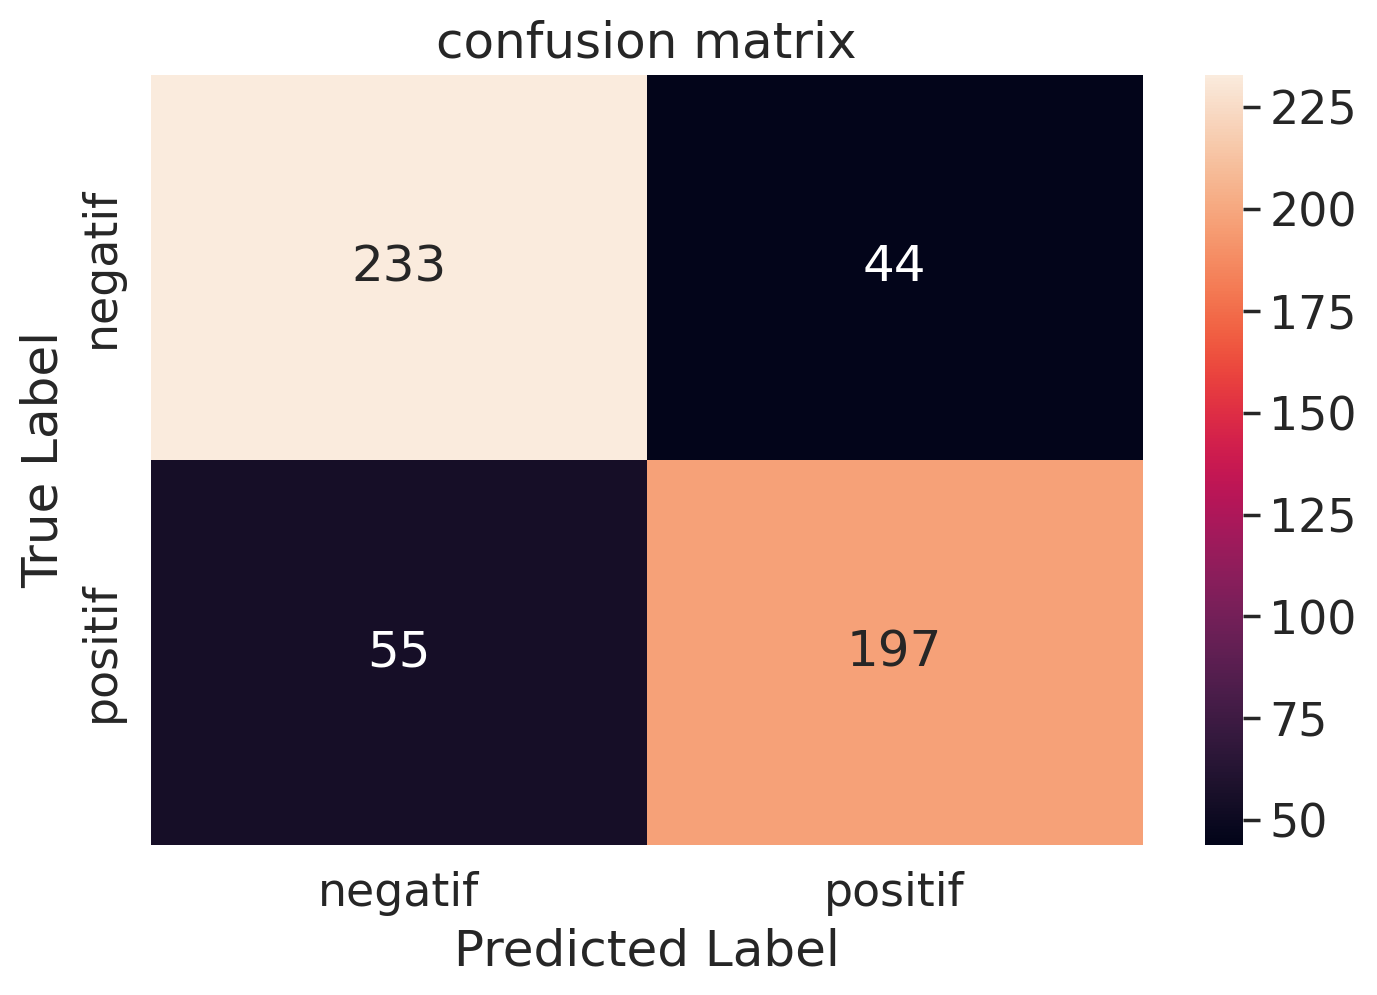

In [ ]:
# confusion matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(flat_true, np.argmax(flat_pred, axis=1))).rename(columns=num_to_label, index=num_to_label)
sns.heatmap(confusion_matrix_df, annot=True, fmt='').set(title="confusion matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()

# **Saving Model**

In [ ]:
# Save tokenizer
tokenizer.save_pretrained('SA-INDO-BERT-MODEL/')

('SA-INDO-BERT-MODEL/tokenizer_config.json',
 'SA-INDO-BERT-MODEL/special_tokens_map.json',
 'SA-INDO-BERT-MODEL/vocab.txt',
 'SA-INDO-BERT-MODEL/added_tokens.json')

In [ ]:
# Save model Bert
model.save_pretrained('SA-INDO-BERT-MODEL/')

# Prediksi dengan Text Lain

In [ ]:
text = """
  setelah pelantikan baik baik saja
"""

# Encode text to subwords
subwords = torch.LongTensor([tokenizer.encode(text)])

# Create DataLoader for single batch processing
data_loader = torch.utils.data.DataLoader(subwords, batch_size=1)

for batch in data_loader:
    batch = batch.to(model.device)

    with torch.no_grad():
        logits = model(batch)[0]

    label = torch.argmax(logits, dim=-1).item()

# Print the result
print(f'Text: {text}\nLabel: {num_to_label[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')


Text: 
  setelah pelantikan baik baik saja

Label: positif (85.912%)


In [ ]:
text = """
  harapannya setelah pelantikan, presiden tidak membuat kebijakan yang merugikan rakyat
"""

# Encode text to subwords
subwords = torch.LongTensor([tokenizer.encode(text)])

# Create DataLoader for single batch processing
data_loader = torch.utils.data.DataLoader(subwords, batch_size=1)

for batch in data_loader:
    batch = batch.to(model.device)

    with torch.no_grad():
        logits = model(batch)[0]

    label = torch.argmax(logits, dim=-1).item()

# Print the result
print(f'Text: {text}\nLabel: {num_to_label[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')


Text: 
  harapannya setelah pelantikan, presiden tidak membuat kebijakan yang merugikan rakyat

Label: positif (65.373%)
